In [1]:
import gc
import hashlib
import json
import os
from collections import Counter
from typing import Callable, List, Optional, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

import pickle as pk
import random

In [2]:
with open("../templates/outputs/metadata_w_examples_merged.json") as f:
    metadatas = json.load(f)

In [19]:
def get_extension(s: str) -> str:
    return s.split(".")[-1]


def change_ext(s: str) -> str:
    file, ext = s.rsplit(".")
    ext = "gif" if ext == "mp4" else "mp4"
    return f"{file}.{ext}"


template_directory = "../templates/outputs/template_data/"
example_directory = "../templates/outputs/template_examples/"

_X, _Y = [], []

templates = set(os.listdir(template_directory))
examples = set(os.listdir(example_directory))
for metadata in tqdm(metadatas):
    template_file = metadata["html_file"] + "." + get_extension(metadata["src"])
    template_id = metadata["Template ID"]

    # Process template
    if template_file not in templates:
        template_file = change_ext(template_file)

    if template_file not in templates:
        print(f"CAN NOT FIND TEMPLATE: {template_file}")
        continue

    template_path = os.path.join(template_directory, template_file)
    _X.append(os.path.abspath(template_path))
    _Y.append(template_id)

    # Process examples
    for example in metadata["examples"]:
        byte_string = example["title"].encode()
        md5_hash = hashlib.md5(byte_string).hexdigest()
        ext = get_extension(example["url"])

        example_filename = f"{md5_hash}_{template_id}.{ext}"
        example_path = os.path.join(example_directory, example_filename)

        if example_filename not in examples:
            example_filename = change_ext(example_filename)

        _X.append(os.path.abspath(example_path))
        _Y.append(template_id)


X_data, Y_data = np.array(_X), np.array([int(y) for y in _Y])
X_data.shape, Y_data.shape

100%|██████████| 5718/5718 [00:00<00:00, 99032.23it/s]

CAN NOT FIND TEMPLATE: -memetemplate-434562526-Mr-Breast-GIF-MeMe.gif


((24136,), (24136,))

(5717,) (36,)


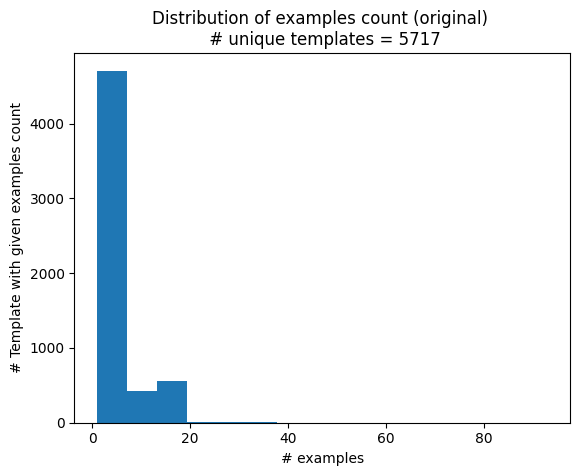

In [20]:
count = Counter(Y_data)
print(np.unique(Y_data).shape, np.unique(list(count.values())).shape)
plt.hist(count.values(), bins=15)
plt.xlabel("# examples")
plt.ylabel("# Template with given examples count")
plt.title(
    f"Distribution of examples count (original) \n # unique templates = {len(np.unique(Y_data))}"
)
plt.savefig("./outputs/Distribution of examples count (original)")

In [21]:
Counter([get_extension(i) for i in X_data])

Counter({'gif': 17757, 'mp4': 6379})

In [22]:
data = [X_data, Y_data]
with open("./outputs/data/raw_data_unbalanced.pkl", "wb") as f:
    pk.dump(data, f)

# Sample data so that dataset is more balance

In [23]:
with open("./outputs/data/raw_data_unbalanced.pkl", "rb") as f:
    X_data, Y_data = pk.load(f)


def sample(data: list, n: int = 40):
    res = []
    count = {}
    added_idx = set()434562526-Mr-Breast-GIF-MeMe

    for _ in range(len(data) * n):
        i = random.randint(0, len(data) - 1)
        elem = data[i]

        if elem not in count and i not in added_idx:
            res.append(i)
            added_idx.add(i)
            count[elem] = 1
        else:
            if count[elem] > n or i in added_idx:
                continue
            else:
                res.append(i)
                added_idx.add(i)
                count[elem] += 1
    return res


def filter_threshold(data: list, n: int = 5):
    count = Counter(data)
    Y_merged = []
    for i in data:
        if count[i] < n:
            Y_merged.append(0)
        else:
            Y_merged.append(i)

    return np.array(Y_merged)

5717 24079


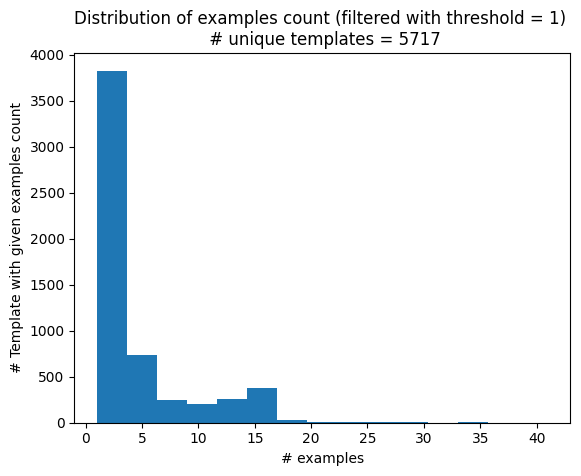

In [24]:
threshold = 1
Y_merged = filter_threshold(Y_data, n=threshold)
idxes = sample(Y_merged)
Y_sampled = Y_merged[idxes]
X_sampled = X_data[idxes]

print(len(np.unique(Y_sampled)), len(Y_sampled))

plt.hist(Counter(Y_sampled).values(), bins=15)
plt.xlabel("# examples")
plt.ylabel("# Template with given examples count")
plt.title(
    f"Distribution of examples count (filtered with threshold = {threshold}) \n # unique templates = {len(np.unique(Y_sampled))}"
)
plt.savefig(
    f"./outputs/Distribution of examples count (filtered with threshold = {threshold}).png"
)

In [25]:
# Fill dataset with duplications

ideal_examples = 15
stat = Counter(Y_sampled)
examples = {}

for i, y in enumerate(Y_sampled):
    if y not in examples:
        examples[y] = []

    examples[y].append(X_sampled[i])

for y in stat:
    if stat[y] >= ideal_examples:
        continue

    remains = ideal_examples - stat[y]
    duplications = random.sample(
        examples[y], k=remains, counts=[remains for _ in range(len(examples[y]))]
    )
    X_sampled = np.append(X_sampled, duplications)
    Y_sampled = np.append(Y_sampled, [y for _ in range(remains)])

In [26]:
X_sampled.shape

(86352,)

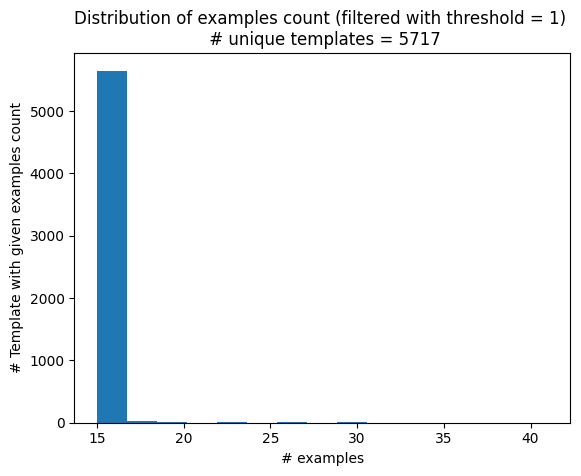

In [27]:
plt.hist(Counter(Y_sampled).values(), bins=15)
plt.xlabel("# examples")
plt.ylabel("# Template with given examples count")
plt.title(
    f"Distribution of examples count (filtered with threshold = {threshold}) \n # unique templates = {len(np.unique(Y_sampled))}"
)
plt.savefig(
    f"./outputs/Distribution of examples count (filtered with threshold = {threshold}).png"
)

In [28]:
Y_sampled[-10:]

array([555414502, 555414502, 555414502, 555414502, 555414502, 555414502,
       555414502, 555414502, 555414502, 555414502])

In [29]:
# SHUFFLE

combined = np.column_stack((X_sampled, Y_sampled))

# Shuffle the combined array
np.random.shuffle(combined)

# Separate the arrays back into X and Y
X_shuffled = combined[:, 0].astype(X_sampled.dtype)  # Retain original dtype
Y_shuffled = combined[:, 1]

print("Shuffled X:", X_shuffled)
print("Shuffled Y:", Y_shuffled)

Shuffled X: ['/home/lehoangchibach/Documents/Code/gif_analytics/templates/outputs/template_data/-memetemplate-397150931-anime-girl-kiss.mp4'
 '/home/lehoangchibach/Documents/Code/gif_analytics/templates/outputs/template_data/-memetemplate-387539723-Anime-gun.mp4'
 '/home/lehoangchibach/Documents/Code/gif_analytics/templates/outputs/template_data/-memetemplate-429437212-Buff-Gustavo-Fring-animated.mp4'
 ...
 '/home/lehoangchibach/Documents/Code/gif_analytics/templates/outputs/template_examples/a3e064cc98a2c968ad67077b72959ab7_492998364.gif'
 '/home/lehoangchibach/Documents/Code/gif_analytics/templates/outputs/template_data/-memetemplate-421747105-mic-drop.mp4'
 '/home/lehoangchibach/Documents/Code/gif_analytics/templates/outputs/template_data/-memetemplate-396556569-Mr-clean-groovy-with-it.mp4']
Shuffled Y: ['397150931' '387539723' '429437212' ... '492998364' '421747105'
 '396556569']


In [31]:
data = [X_sampled, Y_sampled]
with open("./outputs/data/data_sampled_w_duplications_shuffled.pkl", "wb") as f:
    pk.dump(data, f)

(20,) (20,) [306509753]


(array([0., 0., 1., 0.]),
 array([19.5 , 19.75, 20.  , 20.25, 20.5 ]),
 <BarContainer object of 4 artists>)

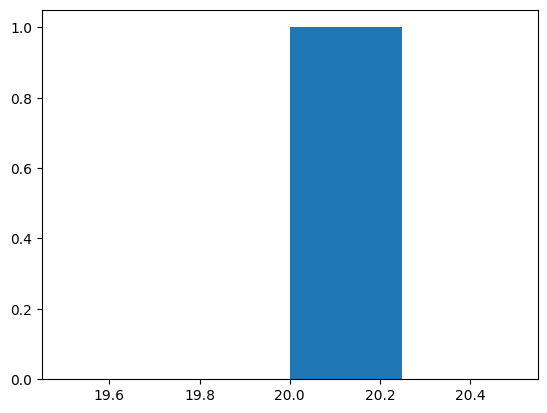

In [15]:
with open("./outputs/data/data_sampled_w_duplications_shuffled.pkl", "rb") as f:
    X_data, Y_data = pk.load(f)

count = Counter(Y_data)
# print(count)

idxes = []
template_id = set(
    [
        370636203,
        306509753,
    ]
)  # 416346667, 418256352])
while len(idxes) < 20:
    idx = random.randint(0, len(Y_data) - 1)
    if Y_data[idx] not in template_id:
        continue

    idxes.append(idx)

Y_smol = Y_data[idxes]
X_smol = X_data[idxes]

print(X_smol.shape, Y_smol.shape, np.unique(Y_smol))
plt.hist(Counter(Y_smol).values(), bins=4)

In [16]:
# data = [X_smol, Y_smol]
# with open("./data/data_sampled_smol_2.pkl", "wb") as f:
#     pk.dump(data, f)